![digitizing_team](digitizing_team.png)


DigiNsure Inc. is an innovative insurance company focused on enhancing the efficiency of processing claims and customer service interactions. Their newest initiative is digitizing all historical insurance claim documents, which includes improving the labeling of some IDs scanned from paper documents and identifying them as primary or secondary IDs.

To help them in their effort, you'll be using multi-modal learning to train an Optical Character Recognition (OCR) model. To improve the classification, the model will use **images** of the scanned documents as input and their **insurance type** (home, life, auto, health, or other). Integrating different data modalities (such as image and text) enables the model to perform better in complex scenarios, helping to capture more nuanced information. The **labels** that the model will be trained to identify are of two types: a primary and a secondary ID, for each image-insurance type pair.

In [12]:
! pip install torchvision

Defaulting to user installation because normal site-packages is not writeable


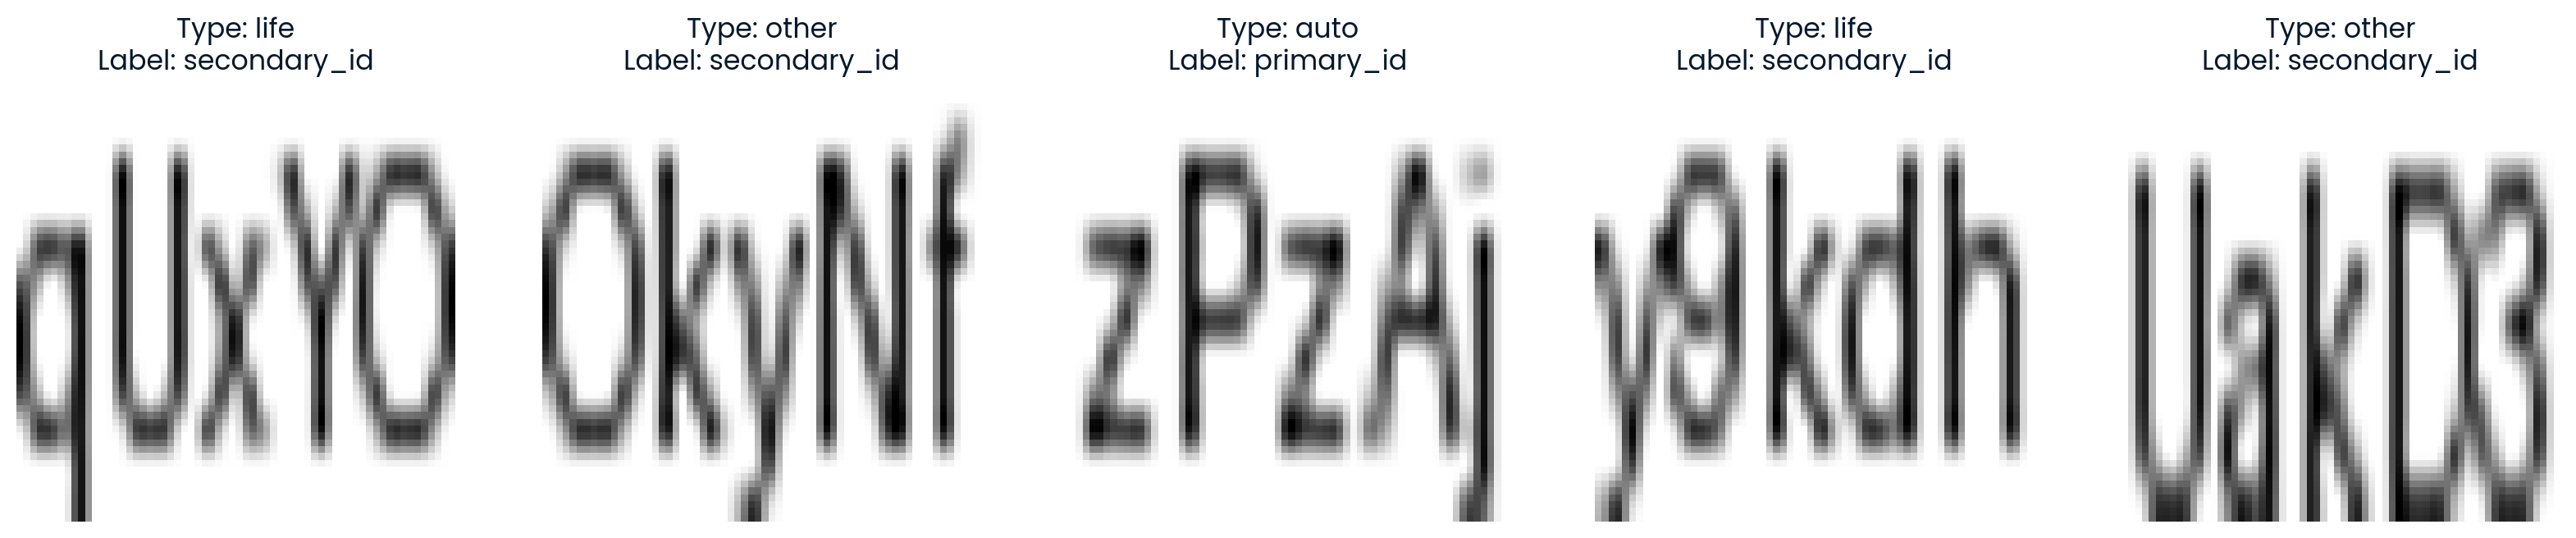

In [13]:
# Import the necessary libraries
import matplotlib.pyplot as plt
import numpy as np
from project_utils import ProjectDataset
import pickle 
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Load the data
dataset = pickle.load(open('ocr_insurance_dataset.pkl', 'rb'))

# Define a function to visualize codes with their corresponding types and labels 
def show_dataset_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, min(num_images, len(dataset)), figsize=(20, 4))
    for ax, idx in zip(axes, np.random.choice(len(dataset), min(num_images, len(dataset)), False)):
        img, lbl = dataset[idx]
        ax.imshow((img[0].numpy() * 255).astype(np.uint8).reshape(64,64), cmap='gray'), ax.axis('off')
        ax.set_title(f"Type: {list(dataset.type_mapping.keys())[img[1].tolist().index(1)]}\nLabel: {list(dataset.label_mapping.keys())[list(dataset.label_mapping.values()).index(lbl)]}")
    plt.show()

# Inspect 5 codes images from the dataset
show_dataset_images(dataset)

In [14]:
# Define the OCRModel class

import torch
import torch.nn as nn
import torch.optim as optim

# Define the OCR Model class
class OCRModel(nn.Module):
    def __init__(self):
        super(OCRModel, self).__init__()

        # Image layer: Convolution, Pooling, Activation, Flatten, Linear
        self.image_layer = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),  # 1 input channel
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # Reduces spatial dimensions
            nn.Flatten(),  # Flattens the feature maps
            nn.Linear(16 * 16 * 16, 128)  # Assuming input image is 32x32
        )

        # Type layer: Fully connected layer for text type
        self.type_layer = nn.Sequential(
            nn.Linear(5, 10),  # 5 input features for type info
            nn.ReLU()
        )

        # Classifier: Combines image and type features
        self.classifier = nn.Sequential(
            nn.Linear(128 + 10, 64)  # Combining image features (128) and type features (10)
        )

    # Define forward pass
    def forward(self, x_image, x_type):
        x_image = self.image_layer(x_image)  # Process image
        x_type = self.type_layer(x_type)    # Process type information
        x = torch.cat((x_image, x_type), dim=1)  # Concatenate along feature dimension
        x = self.classifier(x)              # Pass through classifier
        return x


# Example: Define model, optimizer, and loss function
model = OCRModel()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Dummy data for demonstration (batch_size=8, grayscale image=1x32x32, type=5 classes)
x_image = torch.randn(8, 1, 32, 32)  # Image input (1 input channel)
x_type = torch.randn(8, 5)           # Type input
labels = torch.randint(0, 64, (8,))  # Random target labels (0 to 63)

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()  # Set model to training mode

    # Forward pass
    outputs = model(x_image, x_type)

    # Compute loss
    loss = criterion(outputs, labels)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss at the end of each epoch
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [1/10], Loss: 4.2456
Epoch [2/10], Loss: 1.2370
Epoch [3/10], Loss: 0.2682
Epoch [4/10], Loss: 0.0477
Epoch [5/10], Loss: 0.0138
Epoch [6/10], Loss: 0.0052
Epoch [7/10], Loss: 0.0022
Epoch [8/10], Loss: 0.0011
Epoch [9/10], Loss: 0.0005
Epoch [10/10], Loss: 0.0003


Code Explanation
OCRModel Class

image_layer processes the input image:
Conv2d reduces image channels using 16 filters of size 3x3.
MaxPool2d downsamples the spatial dimensions by 2.
Flatten prepares feature maps for a fully connected layer.
Linear outputs 128 features.
type_layer processes the type vector (size 5) and maps it to a size of 10 using Linear and ReLU.
classifier combines the features from image_layer (128 features) and type_layer (10 features) to produce the final output of size 64.
Forward Pass

The image and type inputs are processed through their respective layers.
Features are concatenated along the feature dimension (dim=1).
Combined features are passed through the classifier.
Optimizer and Loss Function

Adam optimizer is used for optimization.
CrossEntropyLoss is used for multi-class classification.
Training Loop

The model trains for 2 epochs.
Dummy input data simulates batch sizes of 8 with images (3x32x32) and type vectors (5 features).
Loss is printed after each epoch to monitor progress.